# Rolling Windows

In the previous chapter, we placed each row into a single group and then performed an aggregation, returning a single row for each group. In this chapter, we will again group by a fixed period of time, but allow for the start and end period to change to align itself to the current row. The group is constantly sliding down, representing a different "window" of time. This type of analysis is referred to as rolling windows or moving averages.

Take a look at the image below, the rolling mean is the average of three values, the current original value and the two preceding it. The window size here is three. The first two rows lack enough data for the full window size, but a mean can still be calculated.

![1]

[1]: images/rolling_mean.png

## The `rolling` method

The `rolling` method allows you to create windows of time around each row of data. Let's begin by creating the same data from above as a Pandas Series.

In [1]:
import pandas as pd
s = pd.Series([4, 2, 12, 10, 8, 18, 4, 14])
s

0     4
1     2
2    12
3    10
4     8
5    18
6     4
7    14
dtype: int64

### Integer window size

The `rolling` method is similar to `resample`, where the first argument represents the time period. You can pass either an integer or an offset alias as the first argument. As with `resample` (and also `groupby`), calling the `rolling` method by itself informs pandas of the window size. You'll need to chain an additional method to aggregate the values in the current time period. Below, we choose a window size of three, which uses the first value and previous two, and aggregate with the mean.

In [2]:
s.rolling(3).mean()

0     NaN
1     NaN
2     6.0
3     8.0
4    10.0
5    12.0
6    10.0
7    12.0
dtype: float64

By default, missing values are returned whenever there are less values than the window size. Use the parameter `min_periods` to set a different minimum window size. This result now matches the image from the beginning of the chapter.

In [4]:
s

0     4
1     2
2    12
3    10
4     8
5    18
6     4
7    14
dtype: int64

In [3]:
s.rolling(3, min_periods=1).mean()

0     4.0
1     3.0
2     6.0
3     8.0
4    10.0
5    12.0
6    10.0
7    12.0
dtype: float64

Perform multiple aggregations by passing them as strings within a list to the `agg` method. The `size` method is, unfortunately, not available to `rolling` objects. Below, we use `count`, which returns the same number as `size` whenever there are no missing values. We use it here to show the window size.

In [5]:
s.rolling(3, min_periods=1).agg(['min', 'max', 'count'])

,min,max,count
0,4.0,4.0,1.0
1,2.0,4.0,2.0
2,2.0,12.0,3.0
3,2.0,12.0,3.0
4,8.0,12.0,3.0
5,8.0,18.0,3.0
6,4.0,18.0,3.0
7,4.0,18.0,3.0


### Centering the window

Instead of using the current row as the last value in the window, it's possible to use it as the middle value by setting the `center` parameter to `True`. The current row along with previous and following two rows are used below to form a window size of five.

In [6]:
s

0     4
1     2
2    12
3    10
4     8
5    18
6     4
7    14
dtype: int64

In [9]:
s.rolling(3, min_periods=1, center=True).agg('mean')

0     3.0
1     6.0
2     8.0
3    10.0
4    12.0
5    10.0
6    12.0
7     9.0
dtype: float64

## Rolling with offset aliases

Let's read in the stocks dataset, set the index to be a datetime and then select Exxon-Mobil as a Series.

In [10]:
stocks = pd.read_csv('../data/stocks/stocks10.csv', parse_dates=['date'], 
                     index_col='date')
stocks.head(3)

,MSFT,AAPL,SLB,AMZN,TSLA,XOM,WMT,T,FB,V
date,,,,,,,,,,
1999-10-25,29.84,2.32,17.02,82.75,NaN,21.45,38.99,16.78,NaN,NaN
1999-10-26,29.82,2.34,16.65,81.25,NaN,20.89,37.11,17.28,NaN,NaN
1999-10-27,29.33,2.38,16.52,75.94,NaN,20.80,36.94,18.27,NaN,NaN


In [11]:
xom = stocks['XOM']
xom.head()

date
1999-10-25    21.45
1999-10-26    20.89
1999-10-27    20.80
1999-10-28    21.19
1999-10-29    21.47
Name: XOM, dtype: float64

Using an integer window size of five works the same in this Series with a DatetimeIndex as it does with any other Series.

In [12]:
xom.rolling(5, min_periods=1).agg(['mean', 'count']).head(10)

,mean,count
date,,
1999-10-25,21.450000,1.0
1999-10-26,21.170000,2.0
1999-10-27,21.046667,3.0
1999-10-28,21.082500,4.0
1999-10-29,21.160000,5.0
1999-11-01,21.204000,5.0
1999-11-02,21.322000,5.0
1999-11-03,21.394000,5.0
1999-11-04,21.388000,5.0


Window size of a Series (or DataFrame) with a DatetimeIndex may be set with an offset alias. Here, we use `'5D'` for five days. You might assume that this result will be the same as the last, but it is not. When using an offset alias, only the rows within the time period are considered. Since this dataset does not contain weekends, the five day period will only include five observations if the current day is Friday. All the other trading days overlap with one or both weekend days, which do not have rows in the dataset. Take note of the window size under the `'count'` column. Using an integer window size always uses that number of rows in the group (except for the beginning and ending rows).

In [13]:
xom.rolling('5D', min_periods=1).agg(['mean', 'count']).head(10)

,mean,count
date,,
1999-10-25,21.450000,1.0
1999-10-26,21.170000,2.0
1999-10-27,21.046667,3.0
1999-10-28,21.082500,4.0
1999-10-29,21.160000,5.0
1999-11-01,21.443333,3.0
1999-11-02,21.540000,3.0
1999-11-03,21.436667,3.0
1999-11-04,21.367500,4.0


Using a window size of seven days will make the number of observations in each group equal to five as each seven day period will contain exactly one Saturday and one Saturday. The only periods that will have less than five observations are the weeks with federal holidays.

In [14]:
xom.rolling('7D', min_periods=1).agg(['mean', 'count']).head(10)

,mean,count
date,,
1999-10-25,21.450000,1.0
1999-10-26,21.170000,2.0
1999-10-27,21.046667,3.0
1999-10-28,21.082500,4.0
1999-10-29,21.160000,5.0
1999-11-01,21.204000,5.0
1999-11-02,21.322000,5.0
1999-11-03,21.394000,5.0
1999-11-04,21.388000,5.0


### Unavailable offset aliases

Because years, quarter, and months are not fixed time periods, pandas does not allow them to be used as offset aliases within rolling. Here, we verify that using a month does not work. Although weeks are always seven days, they are not allowed either.

In [15]:
xom.rolling('M').mean()

C:\Users\nealv\AppData\Local\Temp\ipykernel_53652\2097950993.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  xom.rolling('M').mean()


ValueError: <MonthEnd> is a non-fixed frequency

## DataFrame `rolling` method

The `rolling` method works similarly on DataFrames. Here we take the mean of each column using a 14 day window size.

In [17]:
stocks.rolling('14D', min_periods=1).mean().round(1).head(10)

,MSFT,AAPL,SLB,AMZN,TSLA,XOM,WMT,T,FB,V
date,,,,,,,,,,
1999-10-25,29.8,2.3,17.0,82.8,NaN,21.4,39.0,16.8,NaN,NaN
1999-10-26,29.8,2.3,16.8,82.0,NaN,21.2,38.0,17.0,NaN,NaN
1999-10-27,29.7,2.3,16.7,80.0,NaN,21.0,37.7,17.4,NaN,NaN
1999-10-28,29.5,2.4,16.7,77.7,NaN,21.1,38.0,18.0,NaN,NaN
1999-10-29,29.6,2.4,16.8,76.3,NaN,21.2,38.2,18.4,NaN,NaN
1999-11-01,29.6,2.4,17.0,75.1,NaN,21.2,38.4,18.7,NaN,NaN
1999-11-02,29.7,2.4,17.0,73.9,NaN,21.3,38.5,18.8,NaN,NaN
1999-11-03,29.7,2.4,17.0,72.9,NaN,21.3,38.5,18.8,NaN,NaN
1999-11-04,29.7,2.4,17.0,71.8,NaN,21.3,38.6,18.9,NaN,NaN


Use the `agg` method to map specific columns to specific aggregations.

In [18]:
stocks.rolling('7D', min_periods=1).agg({'MSFT': 'mean', 'WMT': 'min'}).head()

,MSFT,WMT
date,,
1999-10-25,29.840000,38.99
1999-10-26,29.830000,37.11
1999-10-27,29.663333,36.94
1999-10-28,29.500000,36.94
1999-10-29,29.576000,36.94


### Moving averages

Rolling window averages are commonly referred to as a "moving average", particularly with stock market data. Let's create the 200 day moving average, minimum and maximum for Exxon-Mobil.

In [19]:
xom_stats = xom.rolling(200).agg(['max', 'mean', 'min']).dropna()
xom_stats.head()

,max,mean,min
date,,,
2000-08-08,25.11,23.34560,20.47
2000-08-09,25.11,23.35785,20.47
2000-08-10,25.11,23.37345,20.47
2000-08-11,25.11,23.39005,20.47
2000-08-14,25.11,23.40645,20.47


Visualizing these results can give another perspective on the performance of the stock.

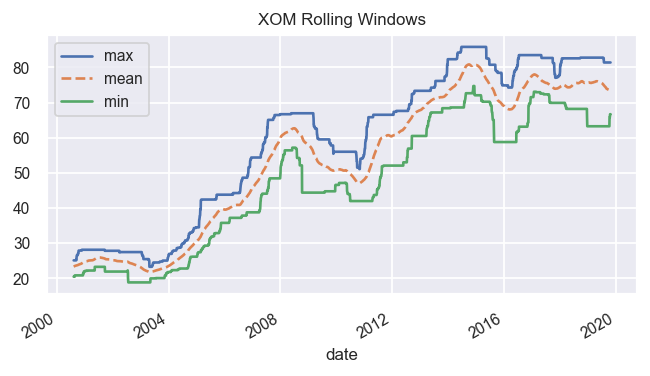

In [20]:
import seaborn as sns
sns.set_theme(rc={'figure.figsize': (5, 2.7), 'figure.dpi': 127}, 
              font_scale=0.8)
xom_stats.plot(figsize=(6, 3), style=['-', '--', '-'], title='XOM Rolling Windows');

## Exercises

Execute the following cell that reads in the temperature dataset and use it for the exercises.

In [21]:
temp = pd.read_csv('../data/weather/temperature.csv', 
                   parse_dates=['datetime'], index_col='datetime')
temp.head()

,Seattle,San Francisco,Los Angeles,Las Vegas,Denver,Houston,Chicago,Atlanta,Miami,New York
datetime,,,,,,,,,,
2013-01-01 00:00:00,2.94,11.50,11.66,7.28,-2.30,8.81,-0.19,1.92,19.41,-1.12
2013-01-01 01:00:00,2.40,10.22,10.67,5.95,-3.23,8.81,0.28,0.60,19.35,-1.69
2013-01-01 02:00:00,1.70,8.02,9.91,5.18,-3.03,8.81,0.33,-0.53,18.99,-1.96
2013-01-01 03:00:00,1.45,7.30,9.33,4.42,-3.67,8.48,0.12,-1.36,18.56,-2.08
2013-01-01 04:00:00,0.95,6.84,8.82,3.62,-5.55,8.34,0.04,-1.44,18.49,-2.32


### Exercise 1

<span style="color:green; font-size:16px">Calculate a 6-hour moving average of temperature. Set the minimum number of rows used in the group to 1.</span>

In [24]:
temp.rolling('6h',min_periods=1).mean()

,Seattle,San Francisco,Los Angeles,Las Vegas,Denver,Houston,Chicago,Atlanta,Miami,New York
datetime,,,,,,,,,,
2013-01-01 00:00:00,2.940000,11.500000,11.660000,7.280000,-2.300000,8.810000,-0.190000,1.920000,19.410000,-1.120000
2013-01-01 01:00:00,2.670000,10.860000,11.165000,6.615000,-2.765000,8.810000,0.045000,1.260000,19.380000,-1.405000
2013-01-01 02:00:00,2.346667,9.913333,10.746667,6.136667,-2.853333,8.810000,0.140000,0.663333,19.250000,-1.590000
2013-01-01 03:00:00,2.122500,9.260000,10.392500,5.707500,-3.057500,8.727500,0.135000,0.157500,19.077500,-1.712500
2013-01-01 04:00:00,1.888000,8.776000,10.078000,5.290000,-3.556000,8.650000,0.116000,-0.162000,18.960000,-1.834000
...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:00:00,-0.610000,6.963333,12.985000,6.730000,-2.813333,16.480000,3.605000,5.856667,21.771667,1.493333
2016-12-31 20:00:00,-0.303333,7.698333,13.058333,7.298333,-1.721667,17.018333,3.565000,6.375000,23.708333,2.660000
2016-12-31 21:00:00,0.191667,8.593333,13.026667,7.801667,0.070000,17.608333,3.368333,6.293333,23.958333,3.741667


### Exercise 2

<span style="color:green; font-size:16px">How many observations are there in each 30-day rolling window of time? Use the `count` method because the `size` method is not available.</span>

In [28]:
temp.rolling('30D', min_periods=1).count().tail()

,Seattle,San Francisco,Los Angeles,Las Vegas,Denver,Houston,Chicago,Atlanta,Miami,New York
datetime,,,,,,,,,,
2016-12-31 19:00:00,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0
2016-12-31 20:00:00,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0
2016-12-31 21:00:00,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0
2016-12-31 22:00:00,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0
2016-12-31 23:00:00,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0,720.0


### Exercise 3

<span style="color:green; font-size:16px">Calculate the 30-day moving average for Los Angeles and Houston using a 1-row minimum. What percentage of the rows does Houston have a higher temperature?</span>

In [29]:
houston = temp['Houston'].rolling('30D', min_periods=1).mean()
los_angeles = temp['Los Angeles'].rolling('30D', min_periods=1).mean()
(houston > los_angeles).mean()

np.float64(0.8586584531143052)

In [32]:
moving_avg_comparison = (temp
    .loc[:, ['Houston', 'Los Angeles']]  # Select columns
    .rolling('30D', min_periods=1)       # Define window once
    .mean()                              # Calculate SMA for both
    # Pipe allows us to access the transformed dataframe to compare cols
    .pipe(lambda df_: (df_['Houston'] > df_['Los Angeles']).mean())
)

moving_avg_comparison

np.float64(0.8586584531143052)

### Exercise 4

<span style="color:green; font-size:16px">Calculate the minimum, maximum, and mean temperatures for Houston using a rolling 14-day period and plot the results.</span>

In [35]:
import matplotlib.pyplot as plt

houston = temp['Houston'].rolling('14D', min_periods=1).agg(['max', 'mean', 'min'])
houston

,max,mean,min
datetime,,,
2013-01-01 00:00:00,8.81,8.810000,8.81
2013-01-01 01:00:00,8.81,8.810000,8.81
2013-01-01 02:00:00,8.81,8.810000,8.81
2013-01-01 03:00:00,8.81,8.727500,8.48
2013-01-01 04:00:00,8.81,8.650000,8.34
...,...,...,...
2016-12-31 19:00:00,27.36,16.475223,-0.82
2016-12-31 20:00:00,27.36,16.450997,-0.82
2016-12-31 21:00:00,27.36,16.429598,-0.82
